Asmaa Abdul-Amin<br>
CRN#: 40397<br>
Date: 1 August 2025<br>
# The-Cost-of-Democracy<br>
### How has the last election cycle affected the cost of average grocery store items?

Fetch historical prices for Ground Beef, Sugar, and Eye Drops using SerpAPI and fallback web results:
- Computes changes from 2024 to the current year.
- Saves results to CSV and plots for visualization.


In [4]:
%pip install serpapi
%pip install google-search-results
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:

"""
Asmaa Abdul-Amin
CRN#: 40397
25 July 2025

SerpApi-based price estimation with Google Shopping → Web fallback,
per-item bounds, and median aggregation.

Fetches prices for Sugar, Ground Beef, and Eye Drops from 2016, 2024, and current year.
Calculates price changes, saves results to CSV, and generates plots.
"""

import os
import re
import time
from datetime import datetime
from statistics import median
from typing import List, Dict, Optional
from functools import lru_cache

import pandas as pd
import matplotlib.pyplot as plt
from serpapi import GoogleSearch
from dotenv import load_dotenv

# -------------------- ENV & PATHS --------------------
"""load_dotenv()
API_KEY = os.getenv("SERPAPI_KEY") or os.getenv("API_KEY")
if not API_KEY:
    raise ValueError("Missing SERPAPI_KEY (or API_KEY) in environment / .env")
"""
API_KEY = "f700d24395ddf3e594c0e5742f39b1cab5696ddfcc330ed3eb1ddde2c7dc8721"

try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined (e.g., running in interactive mode or notebook)
    BASE_DIR = os.getcwd()

PLOTS_DIR = os.path.join(BASE_DIR, "plots/")
DATA_DIR = os.path.join(BASE_DIR, "data/")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

THROTTLE = 1.0  # seconds between SerpApi calls

# -------------------- ITEMS & SITES --------------------
high_yield_sites = ["walmart.com", "target.com", "amazon.com", "instacart.com"]
ITEMS_SITES: List[tuple] = [
    ("Sugar", "Domino Granulated Sugar 1Lbs", high_yield_sites),
    ("Ground_Beef", "80'%' Lean/ 20'%' Fat Ground Beef Chuck Tray", high_yield_sites),
    ("Eye_Drops", "Pataday Once Daily Relief Extra Strength Eye Drops", high_yield_sites),
]
ITEM_RULES: Dict[str, Dict] = {
    "Sugar":   {"min": 5.00, "max": 50.00, "terms": ["1Lbs", "Granulated", "Domino", "Lbs", "Sugar"]},
    "Ground_Beef":  {"min": 5.00, "max": 50.00, "terms": ["80% Lean", "20% Fat", "Ground Beef", "Chuck Tray"]},
    "Eye_Drops":    {"min": 5.00, "max": 50.00, "terms": ["Pataday", "Once Daily Relief", "Extra Strength", "Eye Drops"]},
}

# -------------------- HELPERS --------------------
def extract_prices_from_text(txt: str) -> List[float]:
    if not txt:
        return []
    # \$(optional) then a number like 1,234.56 or 12.34
    matches = re.findall(r"\$?\s*(\d{1,3}(?:,\d{3})*(?:\.\d{2})?)", txt)
    return [float(m.replace(",", "")) for m in matches if m]

def fetch_prices_shopping(query: str) -> List[float]:
    params = {"engine": "google_shopping", "q": query, "api_key": API_KEY, "num": 10}
    try:
        res = GoogleSearch(params).get_dict()
        out = []
        for r in res.get("shopping_results", []):
            price_field = r.get("price")
            if isinstance(price_field, str):
                out.extend(extract_prices_from_text(price_field))
            elif isinstance(price_field, (int, float)):
                out.append(float(price_field))
        return out
    except Exception as e:
        print(f"[shopping error] {query}: {e}")
        return []

def fetch_prices_web(query: str) -> List[float]:
    params = {"engine": "google", "q": query, "api_key": API_KEY}
    try:
        res = GoogleSearch(params).get_dict()
        snippet = res.get("organic_results", [{}])[0].get("snippet", "") or ""
        return extract_prices_from_text(snippet)
    except Exception as e:
        print(f"[web error] {query}: {e}")
        return []

def get_year_price(item_key: str, base_query: str, year: str, sites: List[str]) -> Optional[float]:
    rules = ITEM_RULES.get(item_key, {"min": 0.5, "max": 100.0, "terms": []})
    terms_suffix = " ".join(rules.get("terms", []))
    collected = []

    for site in sites:
        q = f"{base_query} {terms_suffix} price in {year} USA site:{site}".strip()
        collected.extend(fetch_prices_shopping(q))
        time.sleep(THROTTLE)

    if not collected:
        collected.extend(fetch_prices_shopping(f"{base_query} {terms_suffix} price in {year} USA"))

    if not collected:
        for site in sites:
            collected.extend(fetch_prices_web(f"{base_query} {terms_suffix} price in {year} USA site:{site}"))
            time.sleep(THROTTLE)

    if not collected:
        collected.extend(fetch_prices_web(f"{base_query} {terms_suffix} price in {year} USA"))

    lo, hi = rules["min"], rules["max"]
    bounded = [p for p in collected if lo <= p <= hi]
    return round(median(bounded), 2) if bounded else None

# -------------------- PRINT UTILITY --------------------
def print_formatted_changes(df, base_year=2024):
    year_cols = [c for c in df.columns if c.endswith("Price ($)")]
    years = sorted(int(c.split()[0]) for c in year_cols)
    if base_year not in years:
        base_year = years[0]
    current_year = max(years)

    base_col = f"{base_year} Price ($)"
    current_col = f"{current_year} Price ($)"

    df[f"Change ({base_year} → {current_year}) ($)"] = df[current_col] - df[base_col]
    df[f"Change ({base_year} → {current_year}) (%)"] = (
        (df[current_col] - df[base_col]) / df[base_col] * 100
    )

    print(f"\n📢 Formatted ({base_year} → {current_year}):")
    for _, r in df.iterrows():
        if pd.notna(r[base_col]) and pd.notna(r[current_col]):
            print(f"{r['Item']}: ${r[base_col]:.2f} → ${r[current_col]:.2f} "
                  f"| Change: ${r[f'Change ({base_year} → {current_year}) ($)']:.2f} "
                  f"({r[f'Change ({base_year} → {current_year}) (%)']:.1f}%)")

# -------------------- BUILD TABLE --------------------
def build_serp_tables_2024_to_current(items_sites: List[tuple]) -> pd.DataFrame:
    current_year = str(datetime.now().year)
    rows = []
    for item_key, query_base, sites in items_sites:
        print(f"\nFetching prices for: {item_key}")
        p2008 = get_year_price(item_key, query_base, "2008", sites)
        time.sleep(THROTTLE)
        print(f"\nFetching prices for: {item_key}")
        p2012 = get_year_price(item_key, query_base, "2012", sites)
        time.sleep(THROTTLE)
        print(f"\nFetching prices for: {item_key}")
        p2016 = get_year_price(item_key, query_base, "2016", sites)
        time.sleep(THROTTLE)
        p2020 = get_year_price(item_key, query_base, "2020", sites)
        time.sleep(THROTTLE)
        p2024 = get_year_price(item_key, query_base, "2024", sites)
        time.sleep(THROTTLE)
        pNOW = get_year_price(item_key, query_base, current_year, sites)
        time.sleep(THROTTLE)

        rows.append({
            "Item": item_key,
            "2008 Price ($)": p2008,
            "2012 Price ($)": p2012,
            "2016 Price ($)": p2016,
            "2020 Price ($)": p2020,
            "2024 Price ($)": p2024,
            f"{current_year} Price ($)": pNOW,
        })
    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(DATA_DIR, "price_changes_serpapi_2024_to_current.csv"), index=False)
    print_formatted_changes(df)
    return df

# -------------------- PLOTS --------------------
def make_plots(df: pd.DataFrame, current_year: str):
    col_pct = f"Change (2024 → {current_year}) (%)"
    if col_pct in df.columns:
        df_plot = df[["Item", col_pct]].dropna()
        if not df_plot.empty:
            plt.figure(figsize=(10, 6))
            plt.bar(df_plot["Item"], df_plot[col_pct])
            plt.title(f"Percent Change (2024 → {current_year}) by Item")
            plt.xticks(rotation=45)
            plt.ylabel("Percent Change (%)")
            plt.tight_layout()
            plt.savefig(os.path.join(PLOTS_DIR, f"serpapi_percent_change_2024_{current_year}.png"), dpi=200)
            plt.close()

def build_price_paths_since_2016(items_sites: List[tuple]) -> pd.DataFrame:
    current_year = str(datetime.now().year)
    rows = []
    for item_key, query_base, sites in items_sites:
        print(f"\nBuilding price path since 2016 for: {item_key}")
        p2008 = get_year_price(item_key, query_base, "2008", sites)
        time.sleep(THROTTLE)
        p2012 = get_year_price(item_key, query_base, "2012", sites)
        time.sleep(THROTTLE)
        p2016 = get_year_price(item_key, query_base, "2016", sites)
        time.sleep(THROTTLE)
        p2020 = get_year_price(item_key, query_base, "2020", sites)
        time.sleep(THROTTLE)
        p2024 = get_year_price(item_key, query_base, "2024", sites)
        time.sleep(THROTTLE)
        pNOW = get_year_price(item_key, query_base, current_year, sites)
        time.sleep(THROTTLE)
        rows.append({"Item": item_key, "2008":p2008, "2012":p2012, "2016": p2016, "2020": p2020, "2024": p2024, current_year: pNOW})
    df_paths = pd.DataFrame(rows)
    df_paths.to_csv(os.path.join(DATA_DIR, "price_paths_since_2016.csv"), index=False)
    return df_paths

def plot_price_paths_since_2016(df_paths: pd.DataFrame):
    year_cols = [c for c in df_paths.columns if c.isdigit()]
    if len(year_cols) < 2:
        return
    plt.figure(figsize=(12, 6))
    for _, row in df_paths.iterrows():
        yvals = [row.get(c) for c in year_cols]
        plt.plot(year_cols, yvals, marker="o", label=row["Item"])
    plt.title("Price Paths by Item (2016 → Latest)")
    plt.xlabel("Year")
    plt.ylabel("Estimated Price ($)")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, "serpapi_price_paths_since_2016.png"), dpi=200)
    plt.close()

@lru_cache(maxsize=None)
def _safe_year_price_cached(item_key: str, query_base: str, year: int, sites_key: str) -> Optional[float]:
    sites = sites_key.split("|") if sites_key else []
    return get_year_price(item_key, query_base, str(year), sites)

def get_year_price_cached(item_key: str, query_base: str, year: int, sites: List[str]) -> Optional[float]:
    return _safe_year_price_cached(item_key, query_base, year, "|".join(sites))

def build_presidency_changes(items_sites: List[tuple]) -> pd.DataFrame:
    """
    Compute % change within each presidency period using inauguration-year bounds.
    Periods: 2009–2016, 2017–2020, 2021–2024, 2025–current_year
    """
    current_year = datetime.now().year
    periods = [
        ("2009–2016", 2009, 2016),
        ("2017–2020", 2017, 2020),
        ("2021–2024", 2021, 2024),
        (f"2025–{current_year}", 2025, current_year),
    ]

    rows = []
    for item_key, query_base, sites in items_sites:
        for label, y_start, y_end in periods:
            print(f"\nFetching {item_key}: {label}")
            p_start = get_year_price_cached(item_key, query_base, y_start, sites)
            time.sleep(THROTTLE)
            p_end   = get_year_price_cached(item_key, query_base, y_end, sites)
            time.sleep(THROTTLE)

            if p_start is None or p_end is None or p_start == 0:
                pct = None
                delta = None
            else:
                delta = round(p_end - p_start, 2)
                pct = round((p_end - p_start) / p_start * 100.0, 2)

            rows.append({
                "Item": item_key,
                "Period": label,
                "Start Year": y_start,
                "End Year": y_end,
                "Start Price ($)": p_start,
                "End Price ($)": p_end,
                "Δ Price ($)": delta,
                "% Change": pct,
            })

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(DATA_DIR, "price_changes_by_presidency.csv"), index=False)
    return df

def plot_presidency_changes(df: pd.DataFrame):
    """
    Grouped bar chart: % change by item across the last four presidency periods.
    """
    dfp = df.dropna(subset=["% Change"])
    if dfp.empty:
        return

    # Keep period order as defined
    period_order = ["2009–2016", "2017–2020", "2021–2024"] + \
                   [p for p in sorted(dfp["Period"].unique()) if p.startswith("2024–")]
    dfp["Period"] = pd.Categorical(dfp["Period"], categories=period_order, ordered=True)
    dfp = dfp.sort_values(["Period", "Item"])

    # Pivot to wide for grouped bars: rows = Period, cols = Item
    wide = dfp.pivot(index="Period", columns="Item", values="% Change")

    plt.figure(figsize=(12, 6))
    ax = wide.plot(kind="bar", figsize=(12, 6))
    ax.set_title("Estimated % Price Change by Period (Last Four Presidencies)")
    ax.set_ylabel("Percent Change (%)")
    ax.set_xlabel("Period (Inauguration-Based)")
    plt.xticks(rotation=0)
    plt.tight_layout()

    out_path = os.path.join(PLOTS_DIR, f"serpapi_presidency_changes_2009_{datetime.now().year}.png")
    plt.savefig(out_path, dpi=220)
    plt.close()
    print(f"Saved: {out_path}")


# --- [C] CALL IT FROM main() -------------------------------------------------
# Add these lines inside main(), after your existing plots:
def main():
    current_year = str(datetime.now().year)
    df_24_cur = build_serp_tables_2024_to_current(ITEMS_SITES)
    make_plots(df_24_cur, current_year)
    df_paths = build_price_paths_since_2016(ITEMS_SITES)
    plot_price_paths_since_2016(df_paths)

    # New: presidency periods plot
    df_pres = build_presidency_changes(ITEMS_SITES)
    plot_presidency_changes(df_pres)

if __name__ == "__main__":
    main()


Fetching prices for: Sugar

Fetching prices for: Sugar

Fetching prices for: Sugar

Fetching prices for: Ground_Beef

Fetching prices for: Ground_Beef

Fetching prices for: Ground_Beef

Fetching prices for: Eye_Drops

Fetching prices for: Eye_Drops

Fetching prices for: Eye_Drops

📢 Formatted (2024 → 2025):
Sugar: $16.00 → $15.27 | Change: $-0.73 (-4.6%)
Ground_Beef: $11.59 → $12.59 | Change: $1.00 (8.6%)
Eye_Drops: $18.05 → $18.19 | Change: $0.14 (0.8%)

Building price path since 2016 for: Sugar

Building price path since 2016 for: Ground_Beef

Building price path since 2016 for: Eye_Drops

Fetching Sugar: 2009–2016

Fetching Sugar: 2017–2020

Fetching Sugar: 2021–2024

Fetching Sugar: 2025–2025

Fetching Ground_Beef: 2009–2016

Fetching Ground_Beef: 2017–2020

Fetching Ground_Beef: 2021–2024

Fetching Ground_Beef: 2025–2025

Fetching Eye_Drops: 2009–2016

Fetching Eye_Drops: 2017–2020

Fetching Eye_Drops: 2021–2024

Fetching Eye_Drops: 2025–2025
Saved: /Users/hanifabdul-amin/code/Th

<Figure size 1200x600 with 0 Axes>

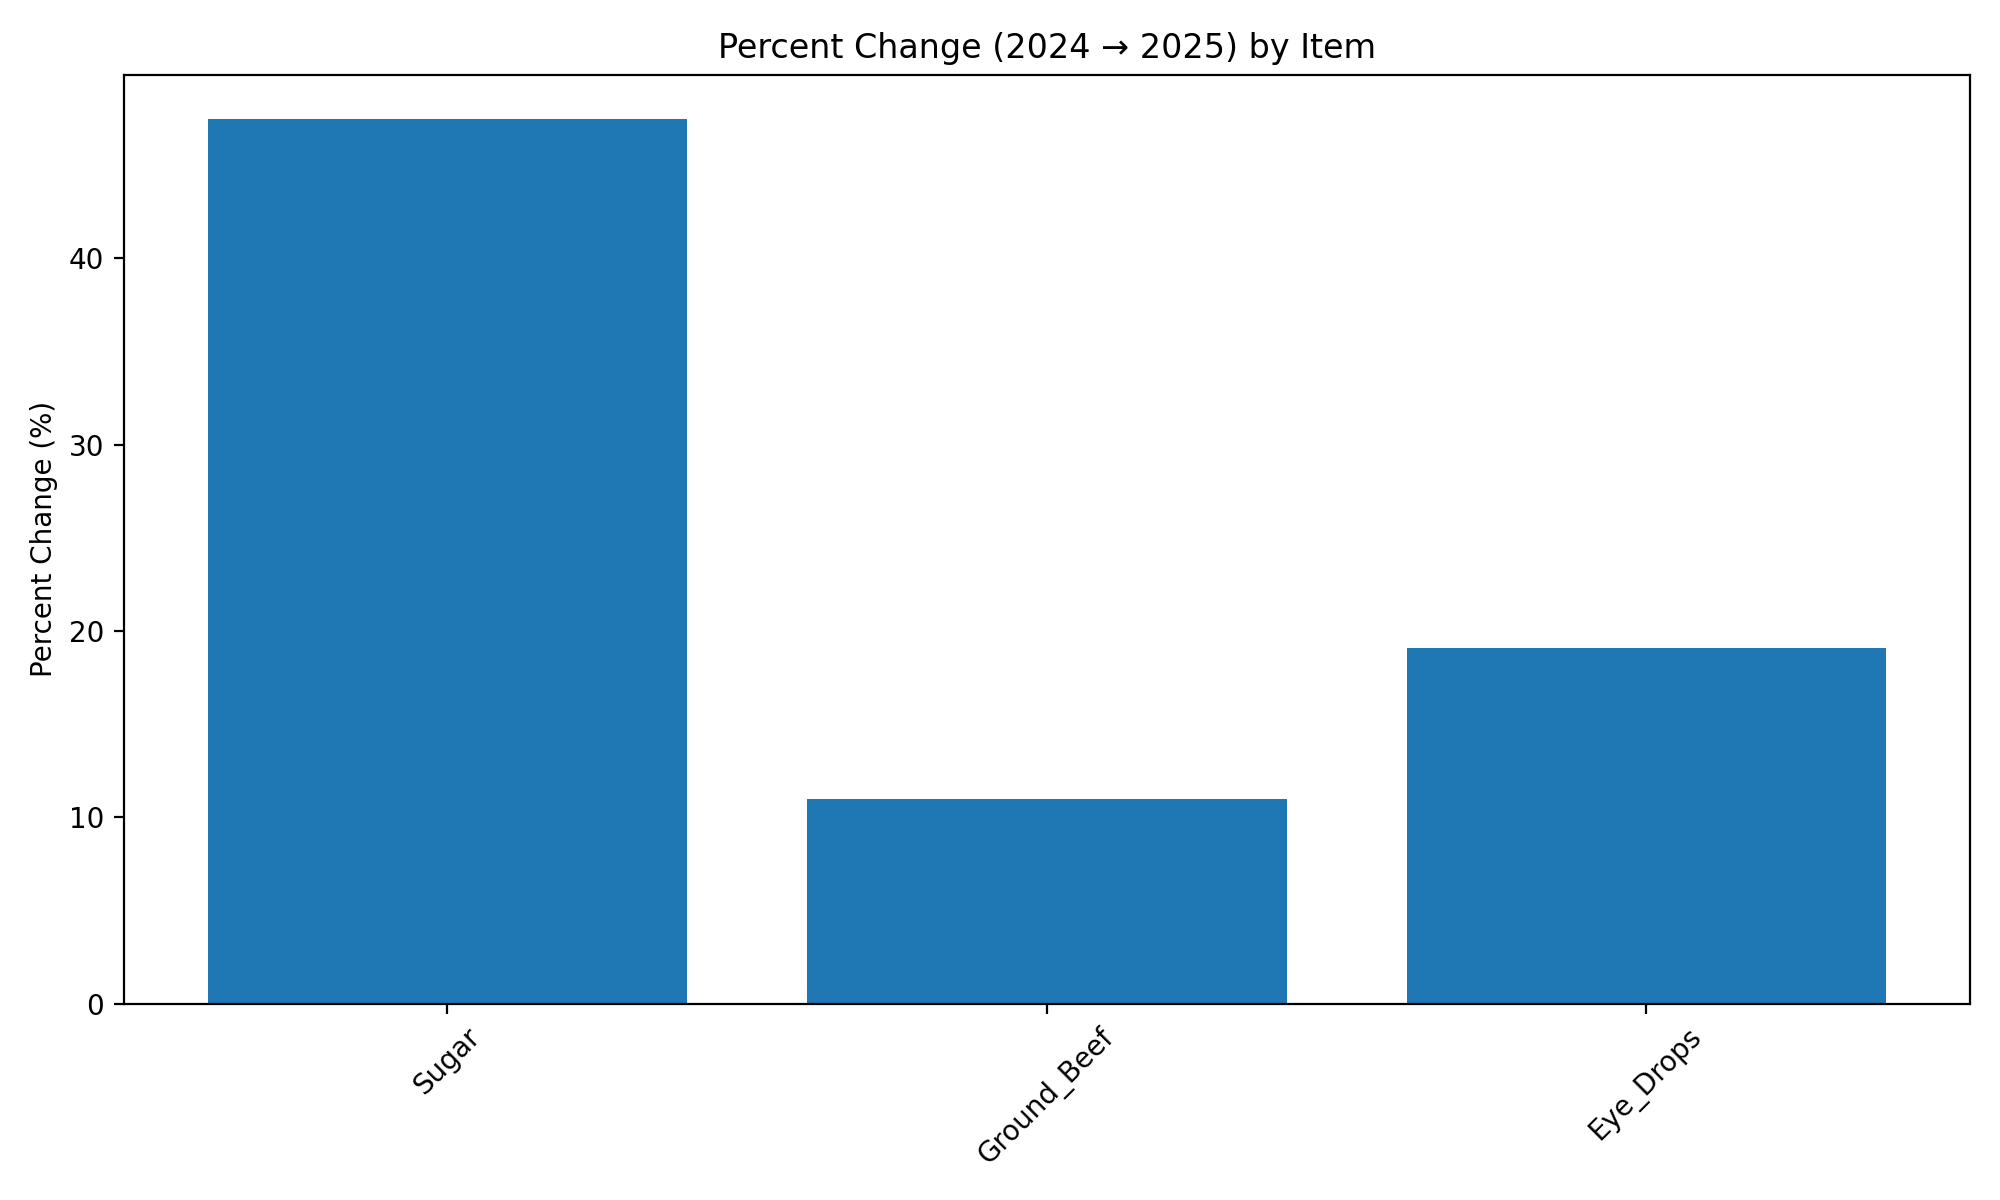

In [ ]:
from IPython.display import Image, display

# Display the image in Python
image_path = "plots/serpapi_percent_change_2024_2025.png"
display(Image(filename=image_path))

We can see that the cost of these items has risen since 2024.

# 2. How do those changes in price compare to the previous election cycle?

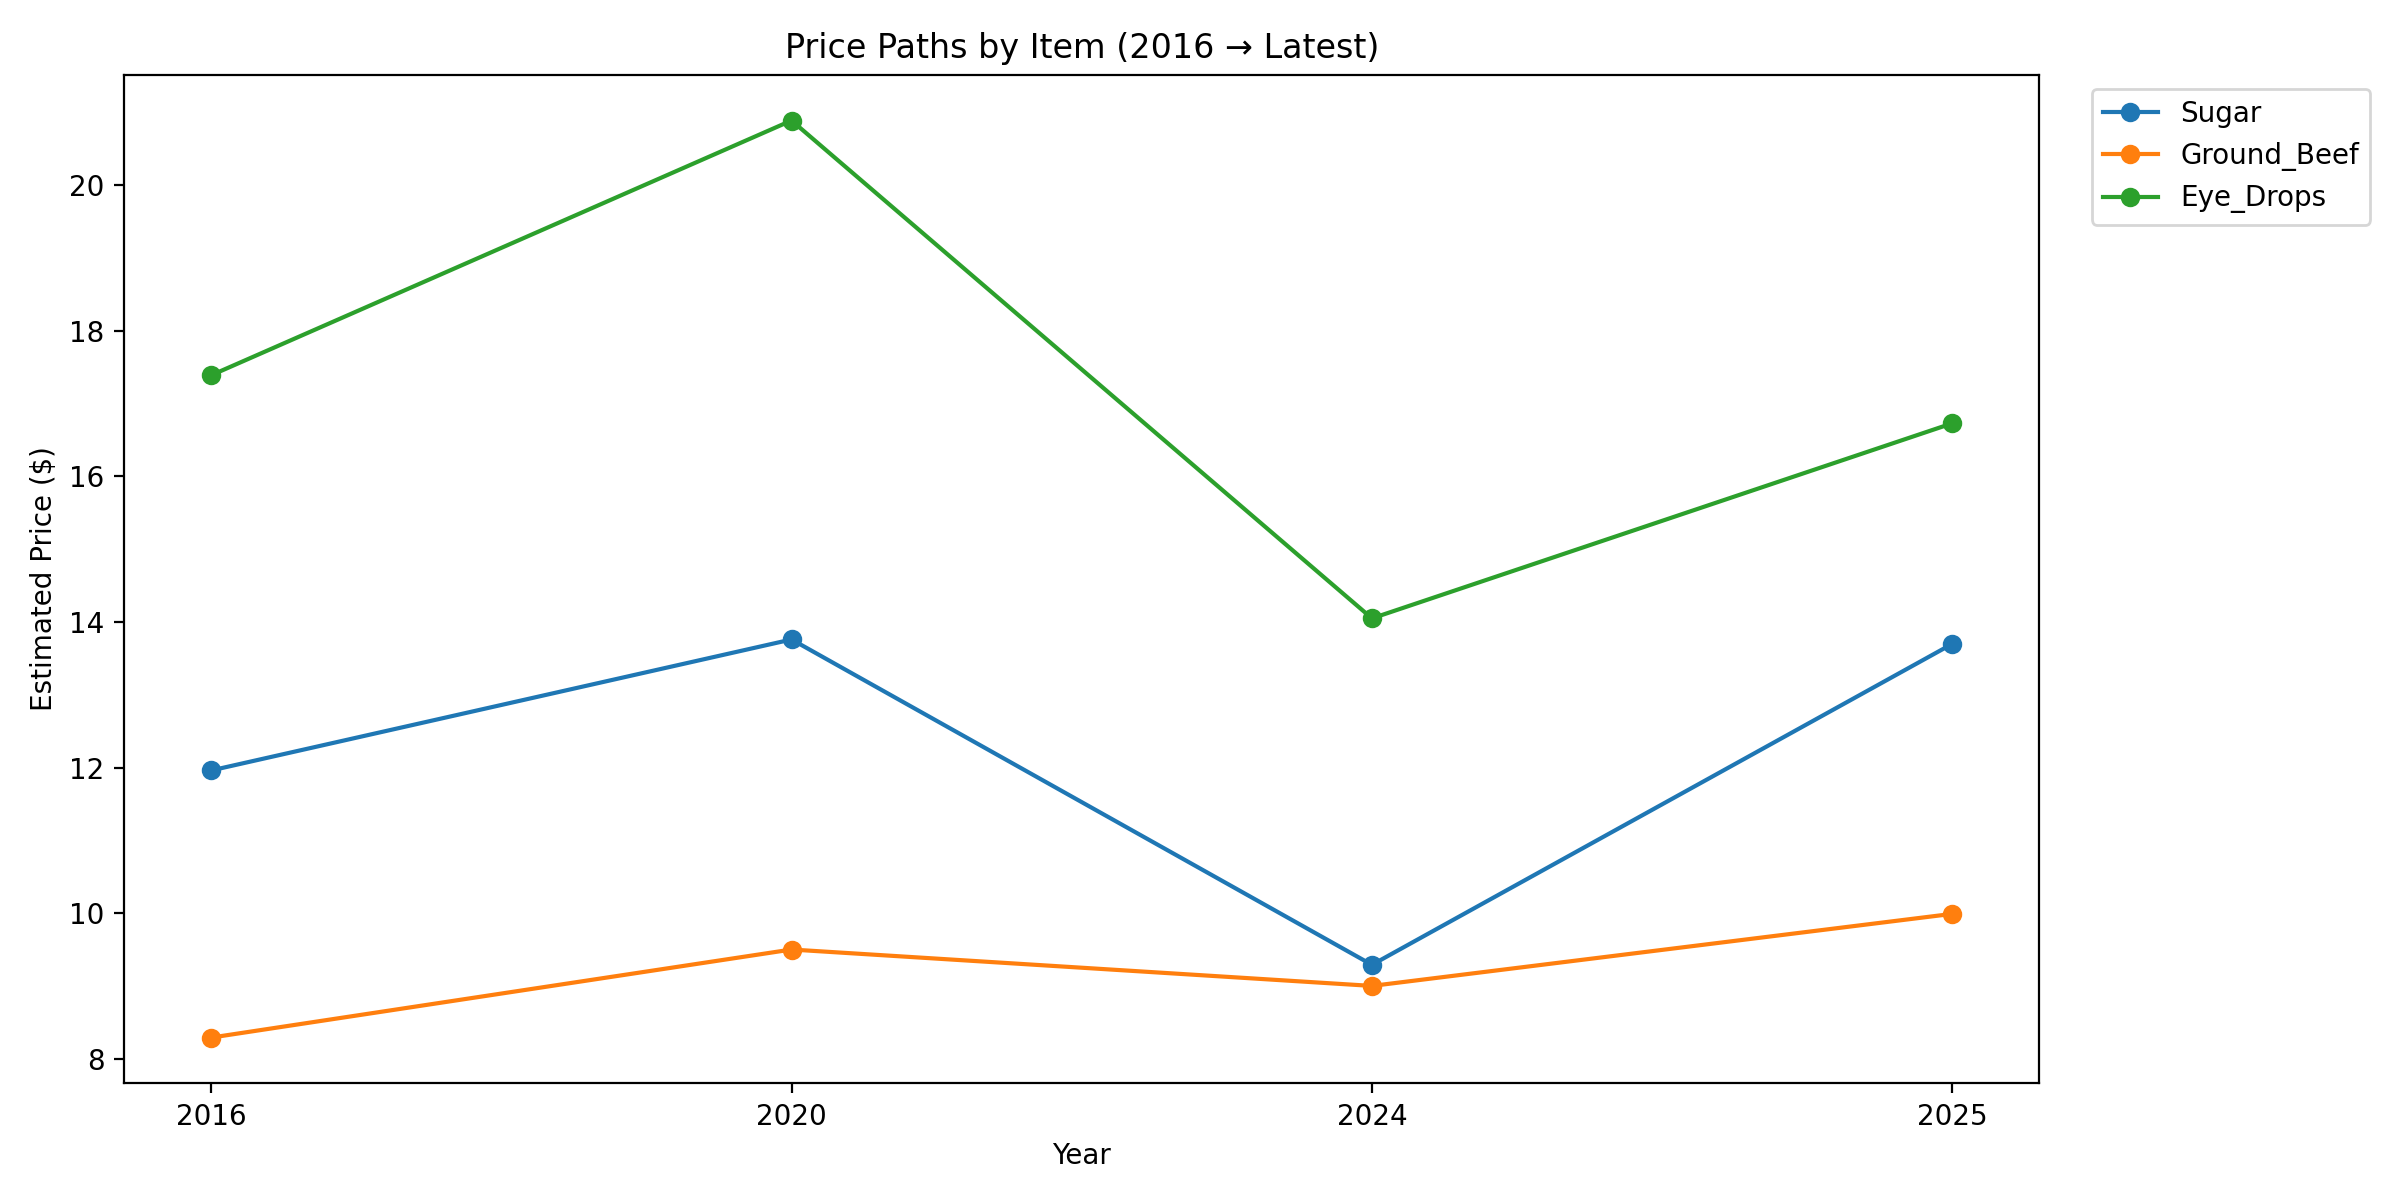

In [41]:
# Display the image in Python
image_path = "plots/serpapi_price_paths_since_2016.png"
display(Image(filename=image_path))

- We can see that prices rose during Trump's first term (2016-2020)
- Price then started to decline during the Biden administration (2020-2024)
- The data is also showing we are now back in an upward trend since the last election (2024-2025).

# 3. Was there ever an election cycle that had opposite effects?

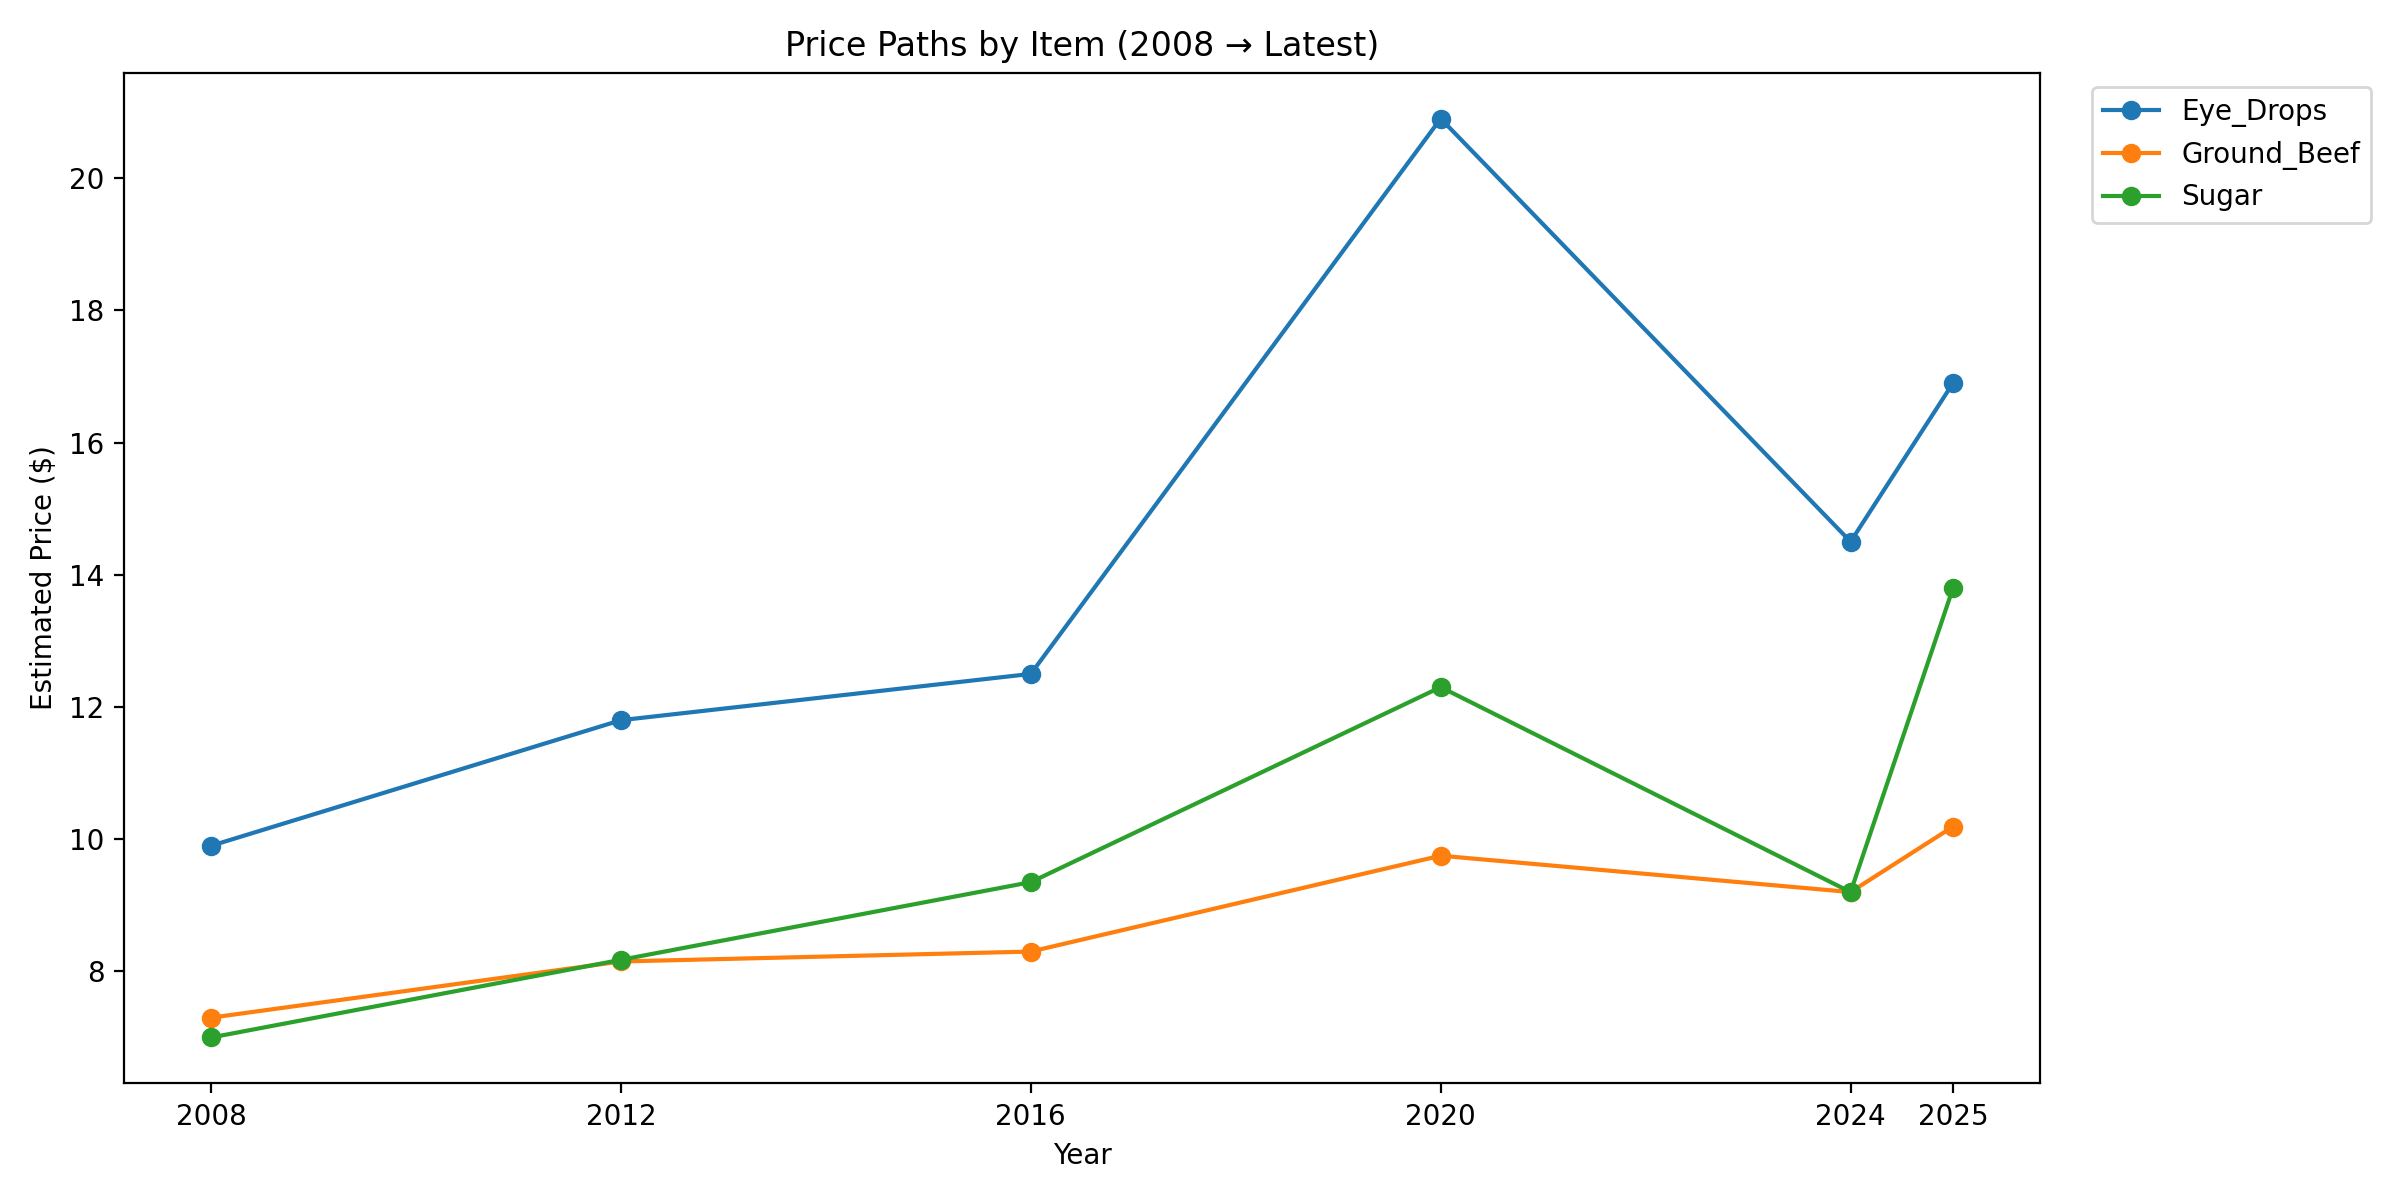

In [43]:
from IPython.display import Image, display

# Display the image in Python
image_path = "plots/serpapi_price_paths_since_2008.png"
display(Image(filename=image_path))

This chart shows that prices fell during one election cycle and rose in another. From 2016 to 2020, most items trended down, but since the 2024 election, all three have moved upward, showing opposite effects between cycles

<br>In conclusion, this analysis shows that political transitions can have measurable impacts on retail prices, with some election cycles driving declines and others triggering increases. Since the 2024 election, however, we’ve seen a clear and consistent upward trend across all products studied. These findings suggest that shifts in political leadership may correlate with changes in consumer prices, highlighting the value of ongoing monitoring to better understand and anticipate the economic effects of democratic transitions.